In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks, Input, Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [19]:
def load_npy_data(data_dir, prefix):
    X = np.load(f"{data_dir}/X_{prefix}.npy")
    Z = np.load(f"{data_dir}/y_{prefix}.npy")
    return X, Z

def minmax_normalize_beats(X_beats):
    # X_beats shape: (n_record, n_beat, 55, 12)
    min_val = X_beats.min(axis=2, keepdims=True)  # min tiap beat per channel (axis=2: 55)
    max_val = X_beats.max(axis=2, keepdims=True)
    X_norm = (X_beats - min_val) / (max_val - min_val + 1e-8)
    return X_norm

def denoise_beats(X_beats, window_length=7, polyorder=2):
    # X_beats shape: (n_record, n_beat, 55, 12)
    # Terapkan savgol_filter untuk setiap record, beat, dan lead
    shape = X_beats.shape
    X_reshaped = X_beats.reshape(-1, shape[2], shape[3])  # (n_record * n_beat, 55, 12)
    denoised = savgol_filter(X_reshaped, window_length=window_length, polyorder=polyorder, axis=1)
    denoised = denoised.reshape(shape)  # kembali ke (n_record, n_beat, 55, 12)
    return denoised


In [23]:
data_dir = 'data_ready_v2'
X_train, y_train = load_npy_data(data_dir, 'train')
X_val, y_val = load_npy_data(data_dir, 'val')
X_test, y_test = load_npy_data(data_dir, 'test')


# Normalize each beat
X_train = minmax_normalize_beats(X_train)
X_val = minmax_normalize_beats(X_val)
X_test = minmax_normalize_beats(X_test)


print("Train beats :", X_train.shape, y_train.shape)
print("Valid beats :", X_val.shape, y_val.shape)
print("Test beats  :", X_test.shape, y_test.shape)

Train beats : (15284, 10, 55, 12) (15284, 5)
Valid beats : (4366, 10, 55, 12) (4366, 5)
Test beats  : (2187, 10, 55, 12) (2187, 5)


In [24]:
# Denoising
X_train_denoised = denoise_beats(X_train)
X_val_denoised = denoise_beats(X_val)
X_test_denoised = denoise_beats(X_test)

# Normalisasi
X_train_filtered = minmax_normalize_beats(X_train_denoised)
X_val_filtered = minmax_normalize_beats(X_val_denoised)
X_test_filtered = minmax_normalize_beats(X_test_denoised)

model making

In [56]:
from tensorflow.keras import Input, Model, layers

def build_cnn_feature_extractor(feat_dim=128, input_shape=(55,12)):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(32, 5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)          # Flatten all time-feature to 1D vector
    x = layers.Dense(feat_dim, activation='relu')(x)
    model = Model(inputs, x, name='beat_cnn')
    return model

cnn_feat_dim = 128
cnn_model = build_cnn_feature_extractor(feat_dim=cnn_feat_dim)


In [57]:
def extract_features_batch(X, cnn_model, batch_size=256):
    # X: (N_record, n_beat, 55, 12)
    N, n_beat, win, n_lead = X.shape
    X_flat = X.reshape(-1, win, n_lead)                # (N_record * n_beat, 55, 12)
    features_flat = cnn_model.predict(X_flat, batch_size=batch_size, verbose=1) # (N_record * n_beat, feat_dim)
    features = features_flat.reshape(N, n_beat, -1)    # (N_record, n_beat, feat_dim)
    return features

# Ekstrak fitur untuk semua data split (proses cukup cepat dengan GPU)
X_train_feat = extract_features_batch(X_train, cnn_model)
X_val_feat   = extract_features_batch(X_val, cnn_model)
X_test_feat  = extract_features_batch(X_test, cnn_model)


598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [65]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GlobalAveragePooling1D

num_classes = y_train.shape[1]
n_beat = X_train_feat.shape[1]
input_feat_dim = X_train_feat.shape[2]

model = Sequential([
    Input(shape=(n_beat, input_feat_dim)),
    LSTM(128, return_sequences=True),    # output: (batch, 128)
    LSTM(64, return_sequences=False),    # output: (batch, 128)
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,477 (724.52 KB)

 Trainable params: 185,477 (724.52 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = model.fit(
    X_train_feat, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val_feat, y_val),
    verbose=1
)

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3926 - loss: 2.2953 - val_accuracy: 0.5021 - val_loss: 2.1293
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3331 - loss: 3.9043 - val_accuracy: 0.4551 - val_loss: 2.2054
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3171 - loss: 2.3487 - val_accuracy: 0.4551 - val_loss: 2.0873
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3366 - loss: 2.1734 - val_accuracy: 0.4551 - val_loss: 2.0913
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3331 - loss: 2.2158 - val_accuracy: 0.4551 - val_loss: 2.1846
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3150 - loss: 2.3053 - val_accuracy: 0.0918 - val_loss: 2.2952
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3060 - loss: 2.3910 - val_accuracy: 0.1773 - val_loss: 3.0667
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2967 - loss: 2.5668 - val_accu

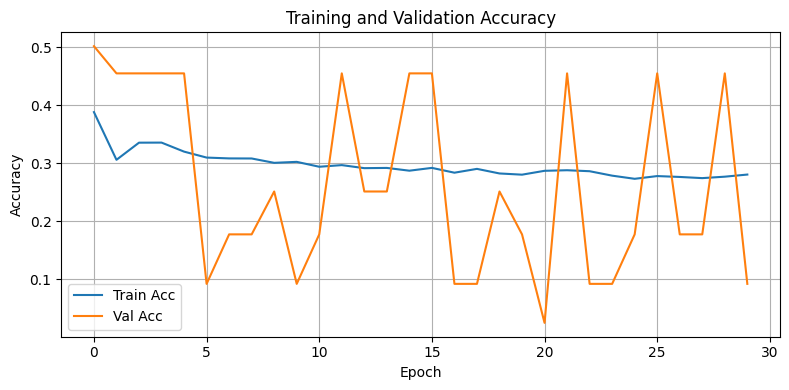

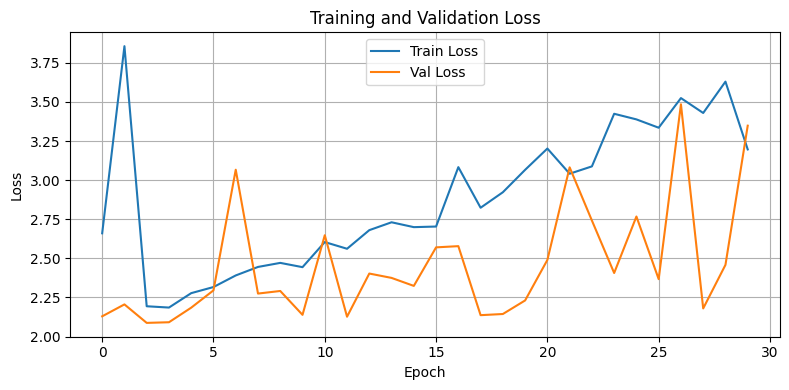

In [67]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Test Loss : 3.3979
Test Accuracy : 0.0924
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


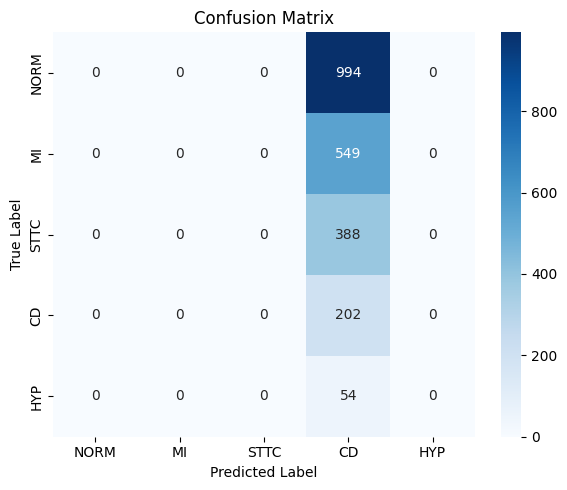

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Pastikan y_true dan y_pred sudah didefinisikan, dan label_names di-set
label_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']  # sesuaikan dengan label Anda
loss, acc = model.evaluate(X_test_feat, y_test, verbose=0)
print(f"Test Loss : {loss:.4f}")
print(f"Test Accuracy : {acc:.4f}")
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prediksi label kelas
y_pred_prob = model.predict(X_test_feat)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:


print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print()
print("Classification Report:")
print(classification_report(y_true, y_pred))


Test Loss : 3.3979
Test Accuracy : 0.0924
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
[[  0   0   0 994   0]
 [  0   0   0 549   0]
 [  0   0   0 388   0]
 [  0   0   0 202   0]
 [  0   0   0  54   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       994
           1       0.00      0.00      0.00       549
           2       0.00      0.00      0.00       388
           3       0.09      1.00      0.17       202
           4       0.00      0.00      0.00        54

    accuracy                           0.09      2187
   macro avg       0.02      0.20      0.03      2187
weighted avg       0.01      0.09      0.02      2187



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TESTTT

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model_lstm = Sequential()

# LSTM layer, tambahkan return_sequences=False karena langsung ke FC
model_lstm.add(LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.3))

# Dense classifier
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation='softmax'))  # 5 kelas (one-hot)

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,773 (315.52 KB)

 Trainable params: 80,773 (315.52 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model_lstm.fit(
    X_train_filtered, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.4f}')


Epoch 1/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - accuracy: 0.2865 - loss: 4.9784 - val_accuracy: 0.1829 - val_loss: 4.7550
Epoch 2/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - accuracy: 0.2719 - loss: 4.6902 - val_accuracy: 0.0920 - val_loss: 9.4801
Epoch 3/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - accuracy: 0.2621 - loss: 7.8420 - val_accuracy: 0.1829 - val_loss: 12.6368
Epoch 4/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 75s 28ms/step - accuracy: 0.2627 - loss: 10.2700 - val_accuracy: 0.2512 - val_loss: 26.1463
Epoch 5/5
2663/2663 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.2657 - loss: 13.9349 - val_accuracy: 0.4495 - val_loss: 35.0545
759/759 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1567 - loss: 4.6494
Test Accuracy: 0.1739
